In [1]:
import torch
from torch import nn as nn # nn contains all of Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

#Check Pytorch version
torch.__version__

'2.0.1'

## 1. Data(preparing and loading )

Let's create our data as a straight line.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [2]:
#Create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
#Create data
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data = X_train,
                     train_label = y_train, 
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
    plt.figure(figsize=(10, 7))

    #Plot train_data in blue
    plt.scatter(train_data, train_label, c='b', s=4, label = "Training Data")
    #Plot test data in green 
    plt.scatter(test_data, test_label, c="g", s=4, label = "Test Data")

    #Plot prediction in red
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")
    plt.legend(prop={"size": 14})

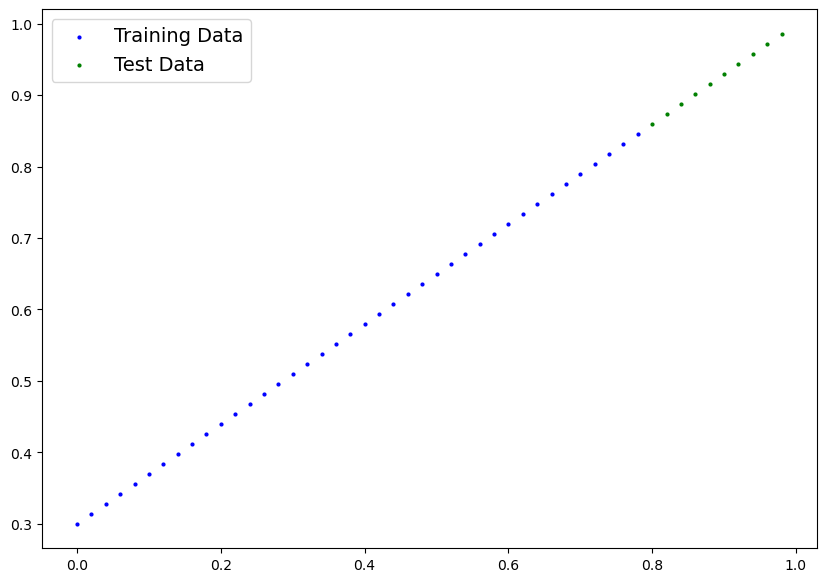

In [5]:
plot_predictions(X_train,y_train, X_test, y_test)

### Build model

Resource: We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading Real Python's Object Orientating programming in Python 3 guide a few times.

In [6]:
#OOP
class Car:
    def __init__(self, color, miles) :
        self.color = color
        self.miles = miles
    def __str__(self) :
        return f'The {self.color} car has {self.miles} miles'

In [7]:
car1 = Car("blue", 20000)
car2 = Car("red", 30000)
print(car1)
print(car2)


The blue car has 20000 miles
The red car has 30000 miles


In [14]:
#Create a Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float),
                                   requires_grad= True) ## <- we update value with gradient descent
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                                 requires_grad= True) ## <- we update value with gradient descent
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

### PyTorch model building essentials

Pytorch has 4 essential modules:
- `torch.nn`
- `torch.optim`
- `torch.utils.data.Dataset`
- `torch.utils.data.DataLoader`

### Checking the contents of Pytorch model

In [19]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using .state_dict().



In [20]:
model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()¶


In [21]:
#Make the predictions with model
with torch.no_grad():
    y_preds = model0(X_test)

# with torch.inference_mode():
#     y_preds = model0(X_test)

Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred. See this Tweet from PyTorch for more.

In [23]:
#Check the prediction
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of prediction made: {len(y_preds)}")
print(f"Predict values\n {y_preds}")

Number of testing samples: 10
Number of prediction made: 10
Predict values
 tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


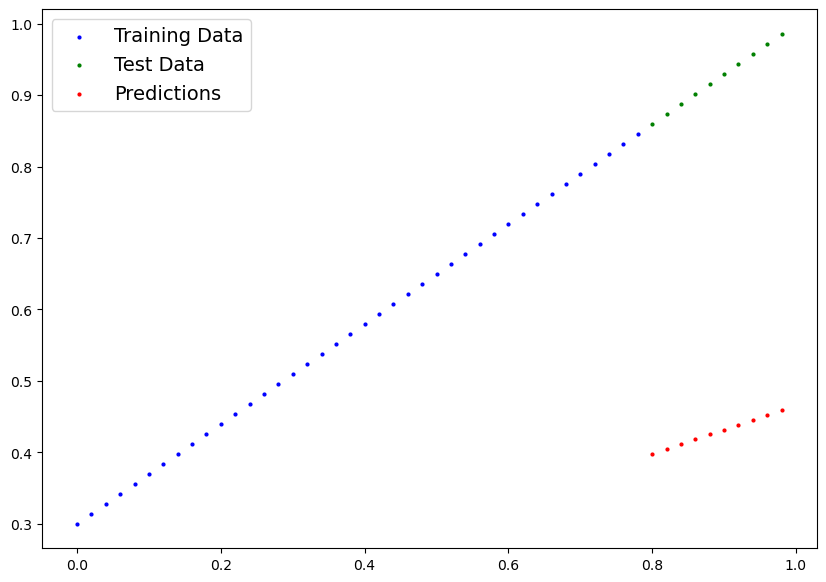

In [24]:
plot_predictions(predictions=y_preds)

## 3. Train model

### Creating a loss function and optimizer in PyTorch¶


In [46]:
#Create a loss function
loss_fn = torch.nn.L1Loss()
#Create the optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.001)

### Creating an optimization loop in PyTorch¶


### PyTorch training loop¶
1. Forward pass
2. Calculate the loss
3. Zero gradients
4. Backpropagation
5. Update the optimizer

### Pytorch testing loop
1. Forward pass
2. Calculate the loss
3. Calculate evulation metric

In [47]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 10 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 20 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 30 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 40 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 50 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 60 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 70 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 80 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 
Epoch: 90 | MAE Train Loss: 0.0007753729587420821 | MAE Test Loss: 0.0006166994571685791 


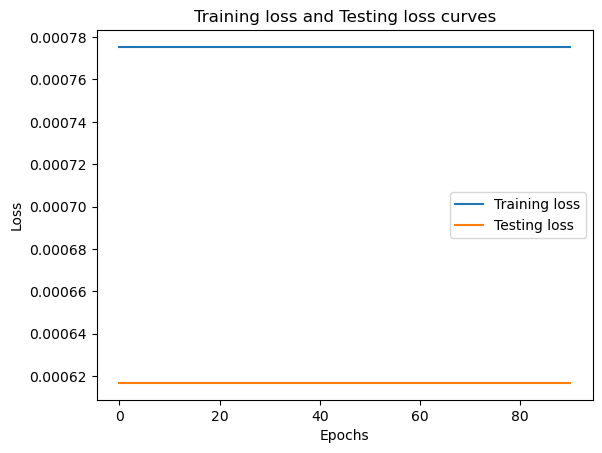

In [48]:
#Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Training loss")
plt.plot(epoch_count, test_loss_values, label = "Testing loss")
plt.title("Training loss and Testing loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [49]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.6999])), ('bias', tensor([0.3008]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained PyTorch model (inference)

In [51]:
# 1. Set the model in evaluation mode
model0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model0(X_test)
y_preds

tensor([[0.8607],
        [0.8747],
        [0.8887],
        [0.9027],
        [0.9167],
        [0.9307],
        [0.9447],
        [0.9587],
        [0.9727],
        [0.9867]])

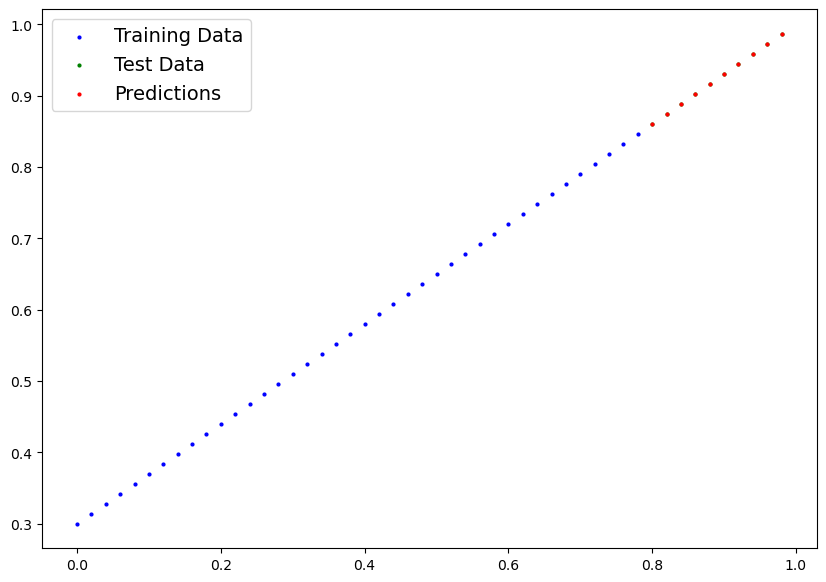

In [52]:
plot_predictions(predictions=y_preds)